# Analysis

In der Phase des Prototyping haben wir vom Datenset erst die ersten 1'000 Zeilen verwendet. Nach den Erkenntnissen aus dem Prototyping laden wir nun die vollständigen Daten auf unseren Cluster.

Der verwendete Datensatz verfügt über zwei Files. Das grosse File steht als CSV-File zur Verfügung, das zweite (Carriers) wird als TXT-File hochgeladen.
Beim Prototyping hat sich gezeigt, dass die Datenmenge beim Speichern als Parquet signifikant reduziert hat. Somit können wir die Performance der Berechnungen verbessern, wenn wir unseren vollständigen Datensatz ebenfalls als Parquet speichern.

### Weshalb Parquet?

Unser Datensatz verfügt über ca. 12GB Daten. Da Parquet auf Geschwindigkeit und Komprimierung optimiert ist, eigent sich dieses Format für solch grosse Datenmengen. Auch verfügt unser Datensatz über 29 Spalten. Bei all unseren Fragestellungen benötigen wir jedoch nur immer einen Bruchteil der Spalten, weshalb das Auslesen der Daten (was immer Zeilenweise geschieht) schneller ist mit Parquet.
Auch haben wir viele identische "NA" Einträge, welche durch die Kompirimierung die Datenmenge signifikant reduziert.

## Bereitstellen der vollständigen Daten

Das Verzeichnis ist bereits aus dem Prototypin vorhanden. Wir werwenden  /airline-data.

In [ ]:
!hdfs dfs -ls /airline-data

In [ ]:
# !hdfs dfs -put ~/BDLC-Project-G01/Dataset/airline.csv /airline-data
# !hdfs dfs -put ~/BDLC-Project-G01/Dataset/carriers.txt /airline-data

In [2]:
!hdfs dfs -ls /airline-data

Found 2 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
-rw-r--r--   2 cluster supergroup      43758 2022-05-12 12:29 /airline-data/carriers.txt


### 1. Daten als Parquet speichern

In [1]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName('ConvertToParquet').getOrCreate()

In [ ]:
!hdfs dfs -ls /airline-data/

### a) Parquet File schreiben

In [ ]:
!hdfs dfs -cat /airline-data/airline.csv | head

In [ ]:
spark.read.csv('/airline-data/airline.csv', header=True).repartition(55).write.parquet('/airline-data/airline.parquet')

In [171]:
!hdfs dfs -ls /airline-data/

Found 2 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
drwxr-xr-x   - cluster supergroup          0 2022-05-22 14:41 /airline-data/carriers.parquet


In [ ]:
!hdfs dfs -cat /airline-data/carriers.txt | head

In [22]:
spark.read.csv('/airline-data/carriers.txt', header=True).repartition(55).write.parquet('/airline-data/carriers.parquet')

In [23]:
!hdfs dfs -ls /airline-data/

Found 3 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
drwxr-xr-x   - cluster supergroup          0 2022-05-22 14:41 /airline-data/carriers.parquet
-rw-r--r--   2 cluster supergroup      43758 2022-05-12 12:29 /airline-data/carriers.txt


### b) Raw File löschen

In [ ]:
!hdfs dfs -rm /airline-data/airline.csv

In [24]:
!hdfs dfs -rm /airline-data/carriers.txt

Deleted /airline-data/carriers.txt


In [173]:
!hdfs dfs -ls /airline-data/

Found 2 items
drwxr-xr-x   - cluster supergroup          0 2022-05-12 12:35 /airline-data/airline.parquet
drwxr-xr-x   - cluster supergroup          0 2022-05-22 14:41 /airline-data/carriers.parquet


### c) Spark-Session stoppen

In [ ]:
# Die SPARK-Sesseion Con
spark.stop()

## Datensatz in Tabelle schreiben

In [ ]:
#!hdfs dfs -mkdir /user/spark/warehouse

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession \
    .builder \
    .appName("SQL with SPARK") \
    .enableHiveSupport() \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-26 11:12:12,984 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


"spark"  ist nun eine existierende SparkSession (siehe: http://bdlc-05.el.eee.intern:8080/ )

In dieser erstellen wir nun ein Dataframe, welches innerhalb dieses Spark-Session verfügbar ist:

### Airline-Daten

In [4]:
df_air = spark.read.parquet("/airline-data/airline.parquet")

In [5]:
df_air.show(n=10)

2022-05-26 11:12:29,573 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|ActualElapsedTime|AirTime|ArrDelay|ArrTime|CRSArrTime|CRSDepTime|CRSElapsedTime|CancellationCode|Cancelled|CarrierDelay|DayOfWeek|DayofMonth|DepDelay|DepTime|Dest|Distance|Diverted|FlightNum|LateAircraftDelay|Month|NASDelay|Origin|SecurityDelay|TailNum|TaxiIn|TaxiOut|UniqueCarrier|WeatherDelay|Year|
+-----------------+-------+--------+-------+----------+----------+--------------+----------------+---------+------------+---------+----------+--------+-------+----+--------+--------+---------+-----------------+-----+--------+------+-------------+-------+------+-------+-------------+------------+----+
|              120|     98|       4|   1214|      1210|       915|           115|            n

### Carrier-Daten

In [6]:
df_carr = spark.read.parquet("/airline-data/carriers.parquet")

In [7]:
df_carr.show(n=10, truncate=False)
#verwendete Option Truncate = damit der Content der Description vollständig aufgeführt wird.

+----+------------------------------------------------+
|Code|Description                                     |
+----+------------------------------------------------+
|AAA |Associated Aviation Act.                        |
|RIA |Trump Air                                       |
|LB  |Lloyd Aereo Boliviano S. A.                     |
|6R  |Aerounion Aerotransporte de Carga Union SA de CV|
|4H  |Belize Trans Air                                |
|MEA |Manhattan Express                               |
|TR  |Transbrasil S.A.                                |
|KL  |Klm Royal Dutch Airlines                        |
|CRN |Crown Aviaiton Inc.                             |
|CHD |Chandler Flyer                                  |
+----+------------------------------------------------+
only showing top 10 rows



## Plausibilisierung des DataFrames

Vor der Bearbeitung der Fragestellungen muss der Datensatz zuerst noch plausibilisiert werden. Hierfür zählen wir die Datensätze:

### Airline

In [8]:
df_air.createOrReplaceTempView("df_air")

In [9]:
anzahlZeilen = spark.sql("SELECT COUNT(FlightNum) FROM df_air")

In [10]:
anzahlZeilen.show()

+----------------+
|count(FlightNum)|
+----------------+
|       123534969|
+----------------+



Die Auswertung zeigt, dass im Datensatz 123.5 Mio Flugzeilen enthalten sind. Dies haben wir über den Datensatz lokal auf dem Laptop verifiziert (:-)= würde natürlich bei einem echten Big-Data-Problem nicht funktionieren.

### Carriers

In [11]:
df_carr.createOrReplaceTempView("df_carr")

In [12]:
anzahlSpediteure = spark.sql("SELECT COUNT(Code) FROM df_carr")

In [13]:
anzahlSpediteure.show()

+-----------+
|count(Code)|
+-----------+
|       1491|
+-----------+



Gemäss den Ausführungen auf Kaggle sind es 1'491 Datensätze. Somit ist der Datensatz korrekt im SPARK vorhanden.

# Fragestellungen

Die nachfolgenden Abfragen können somit nun in der SparkSession und auf dem DataFrame "df" ausgewertet werden.

### Fluggesellschaften (UniqueCarrier)

#### Welche Fluggesellschaften hatte am meisten Verspätungen?

In [49]:
import pyspark.sql.functions as func

flug = spark.sql("""
SELECT Description, UniqueCarrier, SUM(ArrDelay)/60/24 as DelayInDays 
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY Description, UniqueCarrier 
ORDER BY DelayInDays DESC""")
flug2 = flug.withColumn("DelayInDays", func.round(flug["DelayInDays"],0))
#Um die Funktion round zu verwenden, wurden die functions von pyspark.sql importiert

Für die nachfolgenden Plots wurde die Library matplotlib installiert.

In [15]:
#pip install matplotlib

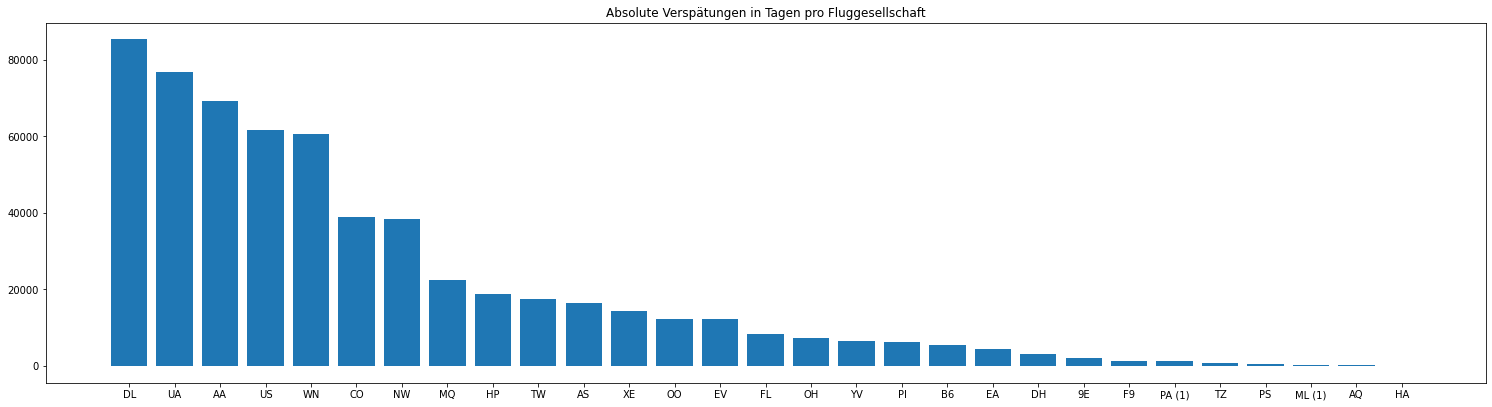

+-----------------------------------------------------------------------------------+-------------+-----------+
|Description                                                                        |UniqueCarrier|DelayInDays|
+-----------------------------------------------------------------------------------+-------------+-----------+
|Delta Air Lines Inc.                                                               |DL           |85315.0    |
|United Air Lines Inc.                                                              |UA           |76865.0    |
|American Airlines Inc.                                                             |AA           |69125.0    |
|US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)|US           |61499.0    |
|Southwest Airlines Co.                                                             |WN           |60555.0    |
|Continental Air Lines Inc.                                                         |CO           |38772

In [16]:
import matplotlib.pyplot as plt
import pandas

dfPlot = flug2

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot.toPandas()["UniqueCarrier"].values.tolist()
y=dfPlot.toPandas()["DelayInDays"].values.tolist()
ax.set_title('Absolute Verspätungen in Tagen pro Fluggesellschaft')
ax.bar(x,y)
plt.show()

dfPlot.show(truncate=False)

Absolut betrachtet hat die Fluggesellschaft DL (Delta Air Lines) insgesamt die längsten Verspätungen mit insgesamt 85'315 Tagen. Über die Qualität darf hierauf jedoch noch keine Aussage getroffen werden, denn wer mehr fliegt, hat evtl. auch mehr Verspätungen. Deshalb ist die relative Verspätung in der nächsten Frage abgehandelt.

#### Welche Fluggesellschaften haben prozentual (+/-) die grössten Abweichungen der geplanten Flugzeit zur effektiven Flugzeit (geplante Abflugzeit bis effektive Ankunftszeit)?

In [71]:
import pyspark.sql.functions as func
flug3 = spark.sql("""
SELECT Description, UniqueCarrier, SUM(ArrDelay)/SUM(AirTime)*100 as DelayPercentage 
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY Description, UniqueCarrier
ORDER BY DelayPercentage DESC""")
flug4 = flug3.withColumn("DelayPercentage", func.round(flug3["DelayPercentage"],3))

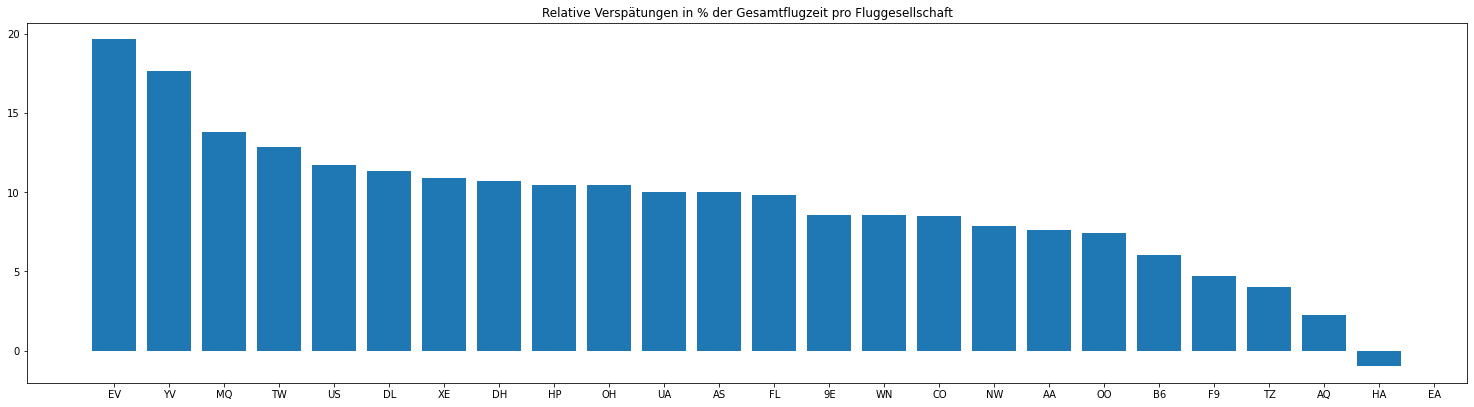

+-----------------------------------------------------------------------------------+-------------+---------------+
|Description                                                                        |UniqueCarrier|DelayPercentage|
+-----------------------------------------------------------------------------------+-------------+---------------+
|Atlantic Southeast Airlines                                                        |EV           |19.651         |
|Mesa Airlines Inc.                                                                 |YV           |17.612         |
|American Eagle Airlines Inc.                                                       |MQ           |13.763         |
|Trans World Airways LLC                                                            |TW           |12.848         |
|US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)|US           |11.705         |
|Delta Air Lines Inc.                                                   

In [72]:
import matplotlib.pyplot as plt
import pandas

dfPlot = flug4

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot.toPandas()["UniqueCarrier"].values.tolist()
y=dfPlot.toPandas()["DelayPercentage"].values.tolist()
ax.set_title('Relative Verspätungen in % der Gesamtflugzeit pro Fluggesellschaft')
ax.bar(x,y)
plt.show()

dfPlot.show(50,truncate=False)

Relativ betrachtet hat die Fluggesellschaft EV (Atlantic Southeast Airlines) die meisten Verspätungen im Verhältnis zur absoluten Flugzeit. Nämlich 19.6% der Gesamten Flugzeit. Zu erwähnen ist, dass die EV bei einer lediglich absoluten Betrachtung "nur" an 14. Stelle wäre, weshalb das relative Verhältnis mit der gesamten Flugzeit relevant ist, um eine Qualitäts-Aussage über die Fluggesellschaft zu fällen.
Es fällt auf, dass die HA insgesamt früher landet als geplant, weshalb es mit -1% am zuverlässigsten ist (oder am üpigsten einplant :) ).

Zusätzlich fällt auf, dass nach HA viele weitere Fluggesellschaften die AirTime nicht im Datensatz enthalten sind (bzw. mit NA geliefert werden). Diese werden in den Auswertungen nicht gerechnet und sind somit nicht einbezogen.

In [83]:
# Eruierung, welcher Wert bei "null" nicht vorhanden ist => AirTime:

import pyspark.sql.functions as func
flug13 = spark.sql("""
SELECT Description, UniqueCarrier, SUM(ArrDelay) AS ArrDelaySum, CAST(SUM(AirTime) AS BIGINT) AS AirTimeSum
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code
WHERE UniqueCarrier = 'EA' GROUP BY Description, UniqueCarrier""")
flug13.show(truncate=False)

+----------------------+-------------+-----------+----------+
|Description           |UniqueCarrier|ArrDelaySum|AirTimeSum|
+----------------------+-------------+-----------+----------+
|Eastern Air Lines Inc.|EA           |6279305.0  |null      |
+----------------------+-------------+-----------+----------+



In [84]:
#Nachweis, dass für die "null" Fluggesellschaften keine AirTime-Angaben vorliegen (bei ASC kämen zuerst die NA, anschliessend die Values):

controll = spark.sql("""
SELECT UniqueCarrier, AirTime
FROM df_air
WHERE UniqueCarrier = 'EA' AND AirTime <> 'NA'
ORDER BY AirTime ASC
""")
controll.show()

+-------------+-------+
|UniqueCarrier|AirTime|
+-------------+-------+
+-------------+-------+



#### Bei welchen 5 Fluggesellschaften werden die meisten Flüge gestrichen?

In [187]:
flug5 = spark.sql("""
SELECT Description, UniqueCarrier, SUM(Cancelled) as Cancelled 
FROM df_air JOIN df_carr ON df_air.UniqueCarrier = df_carr.Code 
GROUP BY Description, UniqueCarrier 
ORDER BY Cancelled DESC""")
flug5.show(5,truncate=False)

+-----------------------------------------------------------------------------------+-------------+---------+
|Description                                                                        |UniqueCarrier|Cancelled|
+-----------------------------------------------------------------------------------+-------------+---------+
|US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)|US           |291650.0 |
|United Air Lines Inc.                                                              |UA           |290506.0 |
|American Airlines Inc.                                                             |AA           |286889.0 |
|Delta Air Lines Inc.                                                               |DL           |258382.0 |
|Northwest Airlines Inc.                                                            |NW           |214154.0 |
+-----------------------------------------------------------------------------------+-------------+---------+
only showi

In [188]:
flug6 = spark.sql("SELECT Year, SUM(Cancelled) as Cancelled, COUNT(FlightNum) as Anzahl FROM df_air GROUP BY Year ORDER BY Year ASC")
dfPlot = flug6

In [190]:
dfPlot.toPandas()["Year"]

0     1987
1     1988
2     1989
3     1990
4     1991
5     1992
6     1993
7     1994
8     1995
9     1996
10    1997
11    1998
12    1999
13    2000
14    2001
15    2002
16    2003
17    2004
18    2005
19    2006
20    2007
21    2008
Name: Year, dtype: object

In [191]:
dfPlot.toPandas()["Cancelled"]

0      19685.0
1      50163.0
2      74165.0
3      52458.0
4      43505.0
5      52836.0
6      59845.0
7      66740.0
8      91905.0
9     128536.0
10     97763.0
11    144509.0
12    154311.0
13    187490.0
14    231198.0
15     65143.0
16    101469.0
17    127757.0
18    133730.0
19    121934.0
20    160748.0
21    137434.0
Name: Cancelled, dtype: float64

In [192]:
dfPlot.toPandas()["Anzahl"]

0     1311826
1     5202096
2     5041200
3     5270893
4     5076925
5     5092157
6     5070501
7     5180048
8     5327435
9     5351983
10    5411843
11    5384721
12    5527884
13    5683047
14    5967780
15    5271359
16    6488540
17    7129270
18    7140596
19    7141922
20    7453215
21    7009728
Name: Anzahl, dtype: int64

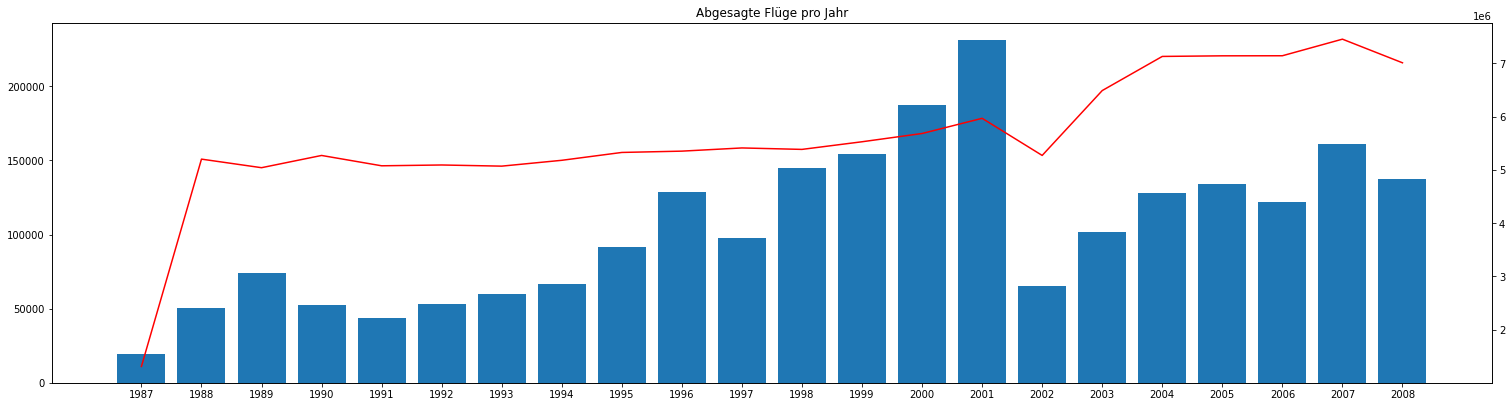

In [189]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
x=dfPlot.toPandas()["Year"].values.tolist()
y1=dfPlot.toPandas()["Cancelled"].values.tolist()
ax.set_title('Abgesagte Flüge pro Jahr')
ax.bar(x,y1)
plt.twinx()
plt.plot(dfPlot.toPandas()["Year"], dfPlot.toPandas()["Anzahl"], color='red')

#### Können Unregelmässigkeiten wie Naturkatastrophen oder Terroranschläge festgestellt werden? 